# ICP #
This notebook is all about ICP and it's different implementations. It should be visual and self - descriptive.

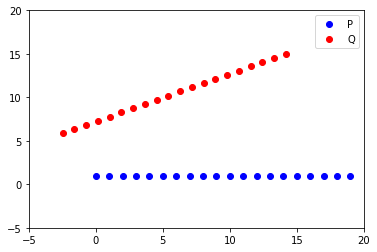

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos
from IPython.display import display, Math, Latex, Markdown
# initialize pertrubation rotation
angle = 0.5
R_true = np.mat([[cos(angle), -sin(angle)], 
               [sin(angle),  cos(angle)]])
t_true = np.mat([[-2], [5]])

# generate data as a list of 2d points
num_points = 20
P = np.mat(np.ones((2, num_points)))
P[0, :] = range(0, num_points)
Q = R_true * P + t_true

# plot the data
def plot_data(P, Q, xlim=[-5, 20], ylim=[-5, 20]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    x_p, y_p = P.A
    x_q, y_q = Q.A
    ax.plot(x_p, y_p, 'bo', label="P")
    ax.plot(x_q, y_q, 'ro', label="Q")
    ax.legend()
    return ax

plot_data(P, Q)
plt.show()

## SVD - based ICP ##

### Theory ###
Given two scans in local frame $P$ and $Q$ we want to align them as good as possible.

#### Iterative solution ####
We say *iteration* and we mean *new point correspondences*. The correct correspondeces are generally not known and are therefore estimated. In this example we will treat the points from $p_{min} \in P$ and $q_{min} \in Q$ as corresponding if:

\begin{equation}
||p_{min} - q_{min}|| = min_{p_i \in P, p_j \in Q}{||p_i - q_j||}
\end{equation}

#### Single iteration ####
In a single iteration we assume that the correspondences are known. We can compute the cross-correlation between the corresponding points. Let $C = \{\{i,j\}:p_i \leftrightarrow q_j\}$ be a set of all correspondences, also $|C| = N$. Then, the cross correlation $K$ is computed as:

\begin{equation}
K = E[(p_i - \mu_P)(q_i - \mu_Q)] = \frac{1}{N}\sum_{\{i,j\} \in C}{(p_i - \mu_P)(q_i - \mu_Q)}
\end{equation}

Each point has two dimentions, that is $p_i, q_j \in {\rm I\!R}$, thus cross correlation has the form of (we drop indices $i$ and $j$ for notation simplicity):

\begin{equation}
K =
  \begin{bmatrix}
    cov(p_x, q_x) & cov(p_x, q_y) \\
    cov(p_y, q_x) & cov(p_y, q_y)
  \end{bmatrix}
\end{equation}

Intuitevely, cross correlation tells us how a coordinate of point $q$ changes with the change of $p$ coorinate, i.e. $cov(p_x, q_x)$ tells us how the $x$ coordinate of $q$ will change with the change in $x$ coordinate of $p$ given that the points are corresponding. Ideal cross correlation matrix seems to be identity, i.e. we want the $x$ coordinates to be ideally correlated between the scans $P$ and $Q$, while there should be no correlation between the $x$ coorinate of points from $P$ to the $y$ coordinate of points in $Q$. 

**Example**: Given scans $P$ and $Q$ that match ideally and $\{p_i, q_j\} \in C$, we know that if we change the $x$ coordinate of $p_i$ we see exactly the same change in $x$ coordinate of $q_j$ while we observe no change in its $y$ coordinate. Therefore, the cross correlation matrix will be identity.

Knowing the cross correlation we can compute its SVD decomposition:

\begin{equation}
\mathrm{SVD}(K) = USV^T
\end{equation}

The SVD decomposition gives us how to rotate our data to align it with its prominent direction with $UV^T$ and how to scale it with its singular values $S$. Therefore:

\begin{eqnarray}
R &=& UV^T \\
t &=& \mu_Q - R \mu_P
\end{eqnarray}

#### Let's try this out: ####

In [102]:
def get_correspondence_indices(P, Q):
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for j in range(q_size):
        q_point = Q[:, j]
        min_dist = 999999999
        chosen_idx = -1
        for i in range(p_size):
            p_point = P[:, i]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = i
        correspondences.append((chosen_idx, j))
    return correspondences

def draw_correspondeces(P, Q, correspondences, ax):
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        ax.plot(x, y, color='grey')
        
def compute_cross_covariance(P, Q, correspondences):
    cov = np.mat([[0., 0.],
                  [0., 0.]])
    for i, j in correspondences:
        p_point = P[:, i]
        q_point = Q[:, j]
        cov += p_point * q_point.T
    return cov

## Correspondences ##
We compute correspondences from $Q$ to $P$, i.e. for every $q_i$ we search the closest $p_j$ to it.

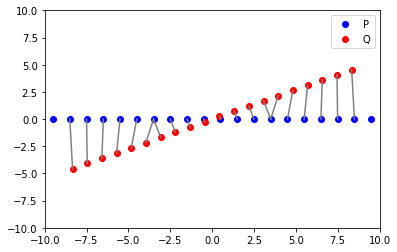

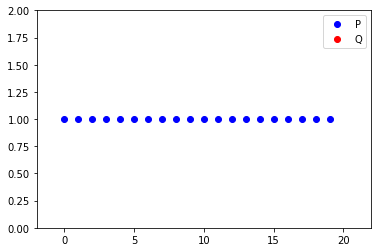

Squared diff: (P - Q_corrected) =  46.6690022584


In [117]:
mu_P = P.mean(1)
mu_Q = Q.mean(1)
P_centered = P - mu_P
Q_centered = Q - mu_Q
correspondences = get_correspondence_indices(P_centered, Q_centered)
lim = [-10, 10]
ax = plot_data(P_centered, Q_centered, lim, lim)
draw_correspondeces(P_centered, Q_centered, correspondences, ax)
plt.show()

cov = compute_cross_covariance(P_centered, Q_centered, correspondences)
U, S, V_T = np.linalg.svd(cov)
R_found = U * V_T
t_found = mu_P - R_found * mu_Q
Q_corrected = R_found * Q_centered + mu_P
ax = plot_data(P, Q_corrected, [-2, 22], [0, 2])
plt.show()
print("Squared diff: (P - Q_corrected) = ", np.linalg.norm(P - Q_corrected))
